In [0]:
!pip3 install pmdarima




     |████████████████████████████████| 1.5MB 8.5MB/s 


In [0]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/monthly-beer-production-in-austr.csv')

df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [0]:
df.shape

(476, 2)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
Month                      476 non-null object
Monthly beer production    476 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [0]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


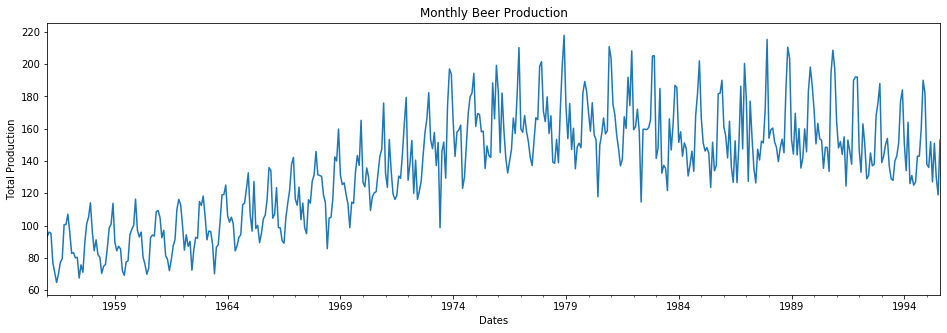

In [0]:
df.index.freq = 'MS'
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

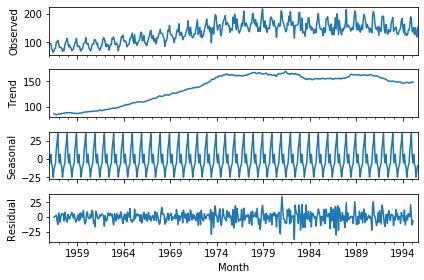

In [0]:
a = seasonal_decompose(df["Monthly beer production"], model = "add")
a.plot();

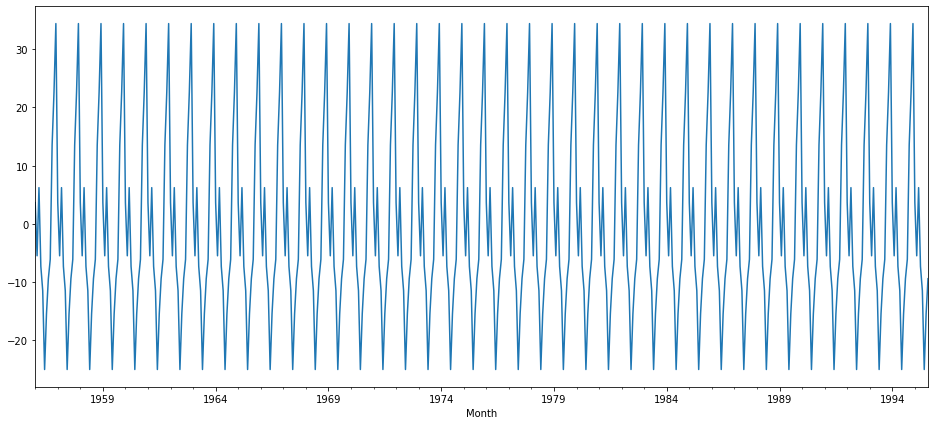

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [0]:
#auto_arima(df['Monthly beer production'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

In [0]:
#split the data into train and test set
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]


In [0]:
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,3), seasonal_order = (3,0,1,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:            Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 3)x(3, 0, 1, 12)   Log Likelihood               -1697.293
Date:                            Tue, 18 Feb 2020   AIC                           3414.585
Time:                                    05:14:13   BIC                           3455.963
Sample:                                01-01-1956   HQIC                          3430.874
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1470      0.005   -219.730      0.000      -1.157      -1.137
ar.L2         -0.9901      0.006   -174.265      0.000      -1.001      -0.979
ma.L1          0.2331      0.026      8.973      0.000       0.182       0.284
ma.L2          0.0026      0.025      0.103      0.918      -0.047       0.053
ma.L3         -0.8571      0.024    -35.408      0.000      -0.905      -0.810
ar.S.L12       0.9910      0.081     12.173      0.000       0.831       1.151
ar.S.L24      -0.0162      0.055     -0.295      0.768      -0.124       0.092
ar.S.L36       0.0163      0.062      0.261      0.794      -0.106       0.139
ma.S.L12      -0.7950      0.068    -11.716      0.000      -0.928      -0.662
sigma2        83.0789      4.601     18.059      0.000      74.062      92.096
===================================================================================
Ljung-Box (Q):                       61.49   Jarque-Bera (JB):                32.87
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")

arima_pred

1994-09-01    134.256563
1994-10-01    157.377792
1994-11-01    179.908988
1994-12-01    181.110974
1995-01-01    141.262719
1995-02-01    139.862042
1995-03-01    148.290301
1995-04-01    133.375199
1995-05-01    137.530604
1995-06-01    117.800210
1995-07-01    129.328103
1995-08-01    140.635141
Freq: MS, Name: ARIMA Predictions, dtype: float64

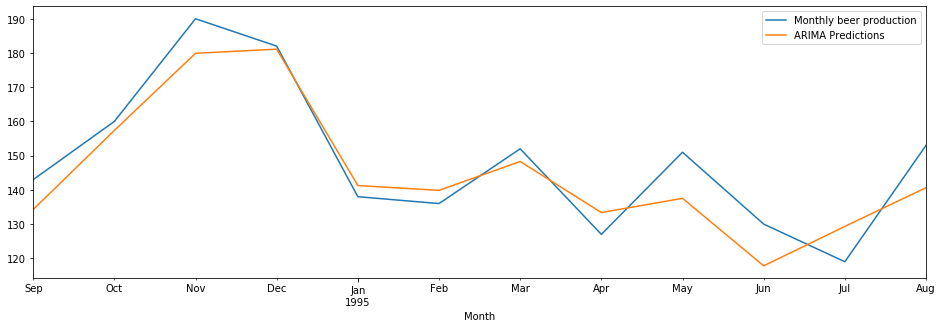

In [0]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)

arima_pred.plot(legend = True);

In [0]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 71.31060257374088
RMSE Error: 8.444560531711575
Mean: 136.39537815126045


In [0]:
test_data['ARIMA_Predictions'] = arima_pred

test_data.head()

,Monthly beer production,ARIMA_Predictions
Month,,
1994-09-01,143.0,134.256563
1994-10-01,160.0,157.377792
1994-11-01,190.0,179.908988
1994-12-01,182.0,181.110974
1995-01-01,138.0,141.262719


## **LSTM Forecast**: 

In [0]:
# scale train and test data with MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [0]:
#Before creating LSTM model create a Time Series Generator object - Utility class for generating batches of temporal data.

from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





452/452 [==============================] - 21s 47ms/step - loss: 0.0240
Epoch 2/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0148
Epoch 3/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0108
Epoch 4/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0092
Epoch 5/20
452/452 [==============================] - 10s 22ms/step - loss: 0.0078
Epoch 6/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0077
Epoch 7/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0076
Epoch 8/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0075
Epoch 9/20
452/452 [==============================] - 10s 22ms/step - loss: 0.0066
Epoch 10/20
452/452 [==============================] - 10s 21ms/step - loss: 0.0064
Epoch 11/20
452/452 [==============================] - 10s 22ms/ste

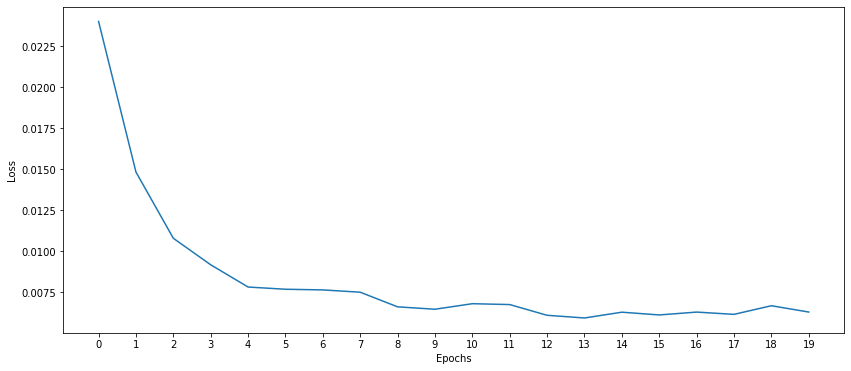

In [0]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(14,6))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [0]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [0]:
lstm_predictions_scaled

[array([0.53044546], dtype=float32),
 array([0.6076127], dtype=float32),
 array([0.73869085], dtype=float32),
 array([0.73938537], dtype=float32),
 array([0.5658425], dtype=float32),
 array([0.53229034], dtype=float32),
 array([0.58906865], dtype=float32),
 array([0.4614873], dtype=float32),
 array([0.4599831], dtype=float32),
 array([0.43892995], dtype=float32),
 array([0.46171993], dtype=float32),
 array([0.5151125], dtype=float32)]

In [0]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

array([[145.95815485],
       [157.76474755],
       [177.81970053],
       [177.92596107],
       [151.37390392],
       [146.24042194],
       [154.92750363],
       [135.40755587],
       [135.1774159 ],
       [131.95628162],
       [135.44314932],
       [143.61221545]])

In [0]:
test_data['LSTM_PREDICTIONS'] = lstm_predictions

test_data

,Monthly beer production,ARIMA_Predictions,LSTM_PREDICTIONS
Month,,,
1994-09-01,143.0,134.256563,145.958155
1994-10-01,160.0,157.377792,157.764748
1994-11-01,190.0,179.908988,177.819701
1994-12-01,182.0,181.110974,177.925961
1995-01-01,138.0,141.262719,151.373904
1995-02-01,136.0,139.862042,146.240422
1995-03-01,152.0,148.290301,154.927504
1995-04-01,127.0,133.375199,135.407556
1995-05-01,151.0,137.530604,135.177416


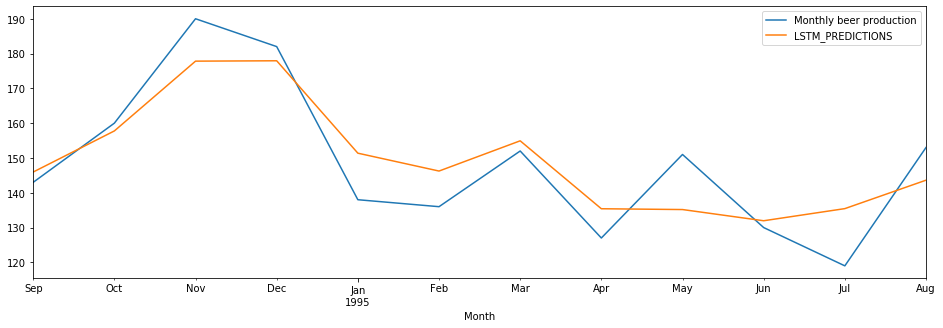

In [0]:
test_data['Monthly beer production'].plot(figsize = (16,5), 
                                          legend=True)
test_data['LSTM_PREDICTIONS'].plot(legend = True);

In [0]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_PREDICTIONS"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 96.19818387814225
RMSE Error: 9.808067285563565
Mean: 136.39537815126045


## **Prophet Forecast:**

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Freq: MS
Data columns (total 1 columns):
Monthly beer production    476 non-null float64
dtypes: float64(1)
memory usage: 7.4 KB


In [0]:
df_pr = df.copy()
df_pr = df_pr.reset_index()

df_pr.columns = ['ds','y'] # To use prophet column names should be like that

train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]

from fbprophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

prophet_pred.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
471,1995-04-01,151.068031,130.392232,156.011733,151.012848,151.126067,-7.935845,-7.935845,-7.935845,-7.935845,-7.935845,-7.935845,0.0,0.0,0.0,143.132187
472,1995-05-01,151.003711,128.188703,152.263786,150.926122,151.091428,-11.400874,-11.400874,-11.400874,-11.400874,-11.400874,-11.400874,0.0,0.0,0.0,139.602837
473,1995-06-01,150.937247,114.905808,139.166743,150.829158,151.049623,-23.933819,-23.933819,-23.933819,-23.933819,-23.933819,-23.933819,0.0,0.0,0.0,127.003428
474,1995-07-01,150.872927,122.899857,146.681602,150.744838,151.008362,-15.749936,-15.749936,-15.749936,-15.749936,-15.749936,-15.749936,0.0,0.0,0.0,135.122992
475,1995-08-01,150.806464,129.119769,154.933476,150.654111,150.965797,-9.223559,-9.223559,-9.223559,-9.223559,-9.223559,-9.223559,0.0,0.0,0.0,141.582905


In [0]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
1994-09-01,145.014244
1994-10-01,166.010984
1994-11-01,173.651126
1994-12-01,185.899777
1995-01-01,155.190582
1995-02-01,146.743233
1995-03-01,158.839055
1995-04-01,143.132187
1995-05-01,139.602837


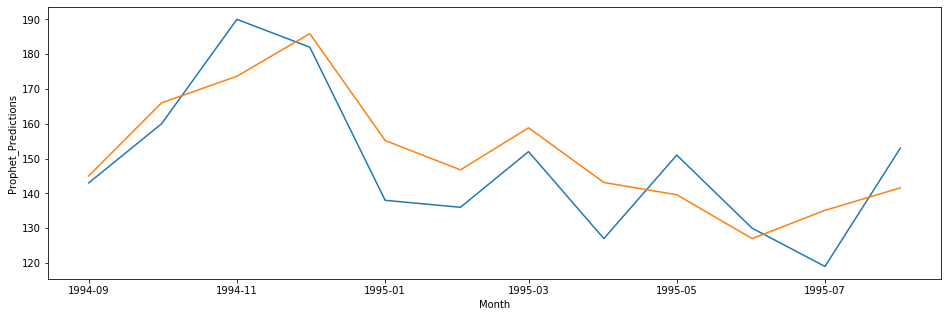

In [0]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Monthly beer production"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [0]:
prophet_rmse_error = rmse(test_data['Monthly beer production'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 130.81766824441812
RMSE Error: 11.437555169021836
Mean: 136.39537815126045


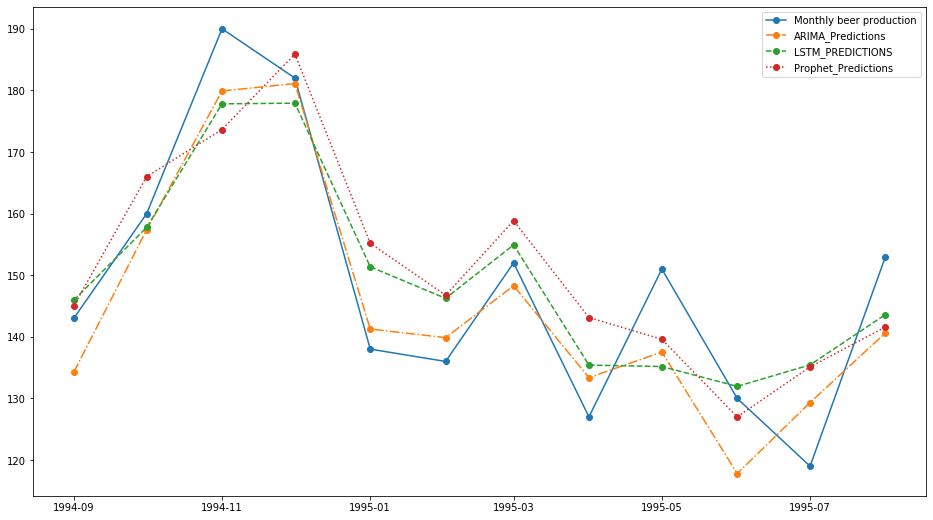

In [0]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Monthly beer production"], linestyle="-", label = 'Monthly beer production' )
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.",  label = 'ARIMA_Predictions' )
plt.plot_date(test_data.index, test_data["LSTM_PREDICTIONS"], linestyle="--", label = 'LSTM_PREDICTIONS')
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":", label = 'Prophet_Predictions')
plt.legend()
plt.show()

In [0]:
print(f"Mean: {test_data['Monthly beer production'].mean()}")

errors

Mean: 148.41666666666666


,Models,RMSE Errors,MSE Errors
0,ARIMA,8.444561,71.310603
1,LSTM,9.808067,96.198184
2,Prophet,11.437555,130.817668


In [0]:
test_data

,Monthly beer production,ARIMA_Predictions,LSTM_PREDICTIONS,Prophet_Predictions
Month,,,,
1994-09-01,143.0,134.256563,145.958155,145.014244
1994-10-01,160.0,157.377792,157.764748,166.010984
1994-11-01,190.0,179.908988,177.819701,173.651126
1994-12-01,182.0,181.110974,177.925961,185.899777
1995-01-01,138.0,141.262719,151.373904,155.190582
1995-02-01,136.0,139.862042,146.240422,146.743233
1995-03-01,152.0,148.290301,154.927504,158.839055
1995-04-01,127.0,133.375199,135.407556,143.132187
1995-05-01,151.0,137.530604,135.177416,139.602837
